#### Q3. [25] LDA Ensemble for Face Recognition
##### 3-1. PCA-LDA
1. recognition accuracies by varying the parameter values, M_pca and M_lda
2. ranks of the scatter matrices
3. the confusion matrix, example success and failure cases
##### 3-2. PCA-LDA Ensemble
1. randomisation in feature space
2. randomisation on data samples (i.e. bagging)
3. the number of base models, the randomness parameter
4. error of the committee machine vs average error of individual models
5. fusion rules
6. recognition accuracy and confusion matrix

In [5]:
import sys
import os
sys.path.append('../')

from dataset.data import split_data
from question3 import pca_lda_modify as plm
from question3 import pca_lda

from scipy import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.stats import mode
import time
import psutil

# https://github.com/RajanPatel97/PCA-and-PCA-LDA-Ensemble-for-Face-Recognition/tree/master

In [2]:
# data split
train_data, train_label, test_data, test_label = split_data(data_path="../dataset/face.mat")
mean_face = np.mean(train_data, axis=1).reshape(-1, 1)

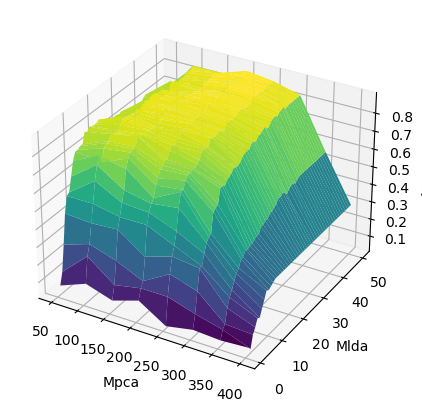

In [12]:
# 3-1-1. accuracy varing M_pca, M_lda

n_nearest = 5
Mpca = []
Mlda = []
accuracy = []

for i in range(1, 416, 50):
    for j in range(1, min(i,51)):
        test_pred = plm.pca_lda_classifier(train_data, train_label, mean_face, test_data, Mpca=i, Mlda=j, knn=n_nearest)
        a = np.mean(test_pred == test_label)
        Mpca.append(i)
        Mlda.append(j)
        accuracy.append(a)

Mpca = np.array(Mpca)
Mlda = np.array(Mlda)
accuracy = np.array(accuracy)

# 2D 격자 생성 (meshgrid)
Mpca_grid, Mlda_grid = np.meshgrid(np.unique(Mpca), np.unique(Mlda))

# Mpca와 Mlda에 맞게 accuracy를 2D 형태로 변환
accuracy_grid = np.zeros_like(Mpca_grid, dtype=float)
for k in range(len(accuracy)):
    # 각 (Mpca, Mlda) 위치에 해당하는 accuracy 값을 채워넣음
    i = np.where(np.unique(Mpca) == Mpca[k])[0][0]
    j = np.where(np.unique(Mlda) == Mlda[k])[0][0]
    accuracy_grid[j, i] = accuracy[k]  # 주의: 행렬에서 (행, 열) 순서로 접근

fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')

ax.plot_surface(Mpca_grid, Mlda_grid, accuracy_grid, cmap='viridis')

ax.set_xlabel('Mpca')
ax.set_ylabel('Mlda')
ax.set_zlabel('Accuracy', rotation=90)

plt.subplots_adjust(left=0.1, right=0.7, bottom=0.1, top=0.9)
plt.show()

# Mpca = 150, Mlda = 50 seems like the best?? when knn=5

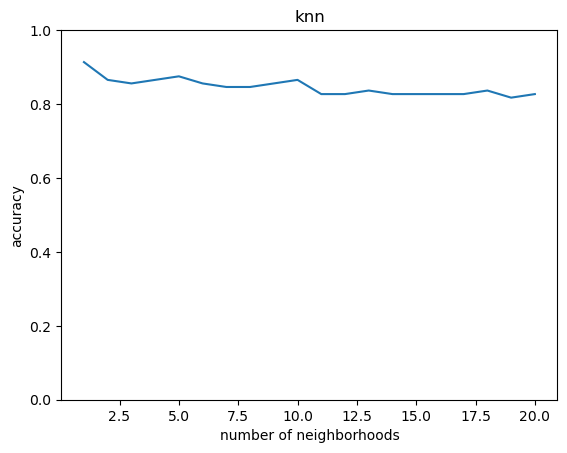

In [ ]:
# 3-1-1 (additional experiment) varing n_nearest

n_nearest = []
accuracy = []

for i in range(1,21):
    test_pred = plm.pca_lda_classifier(train_data, train_label, mean_face, test_data, Mpca=150, Mlda=50, knn=i)
    a = np.mean(test_pred == test_label)
    n_nearest.append(i)
    accuracy.append(a)

n_nearest = np.array(n_nearest)
accuracy = np.array(accuracy)

plt.plot(n_nearest, accuracy)
plt.xlabel('number of neighborhoods')
plt.ylabel('accuracy')
plt.ylim([0.0, 1.0])
plt.title('knn')
plt.show()

# using knn=5, knn=4 is the best and using knn=4, knn=5 is the best omg

In [34]:
# 3-1-2

train_pca_projected = pca_lda.pca_projection(train_data, mean_face, train_data, M=150)

Sw_rank, Sb_rank = pca_lda.lda(train_data.astype(np.float64), train_label.astype(np.uint8), scatter=True)
pca_Sw_rank, pca_Sb_rank = pca_lda.lda(train_pca_projected.astype(np.float64), train_label.astype(np.uint8), scatter=True)

print(Sw_rank, Sb_rank)
print(pca_Sw_rank, pca_Sb_rank)

364 51
150 51


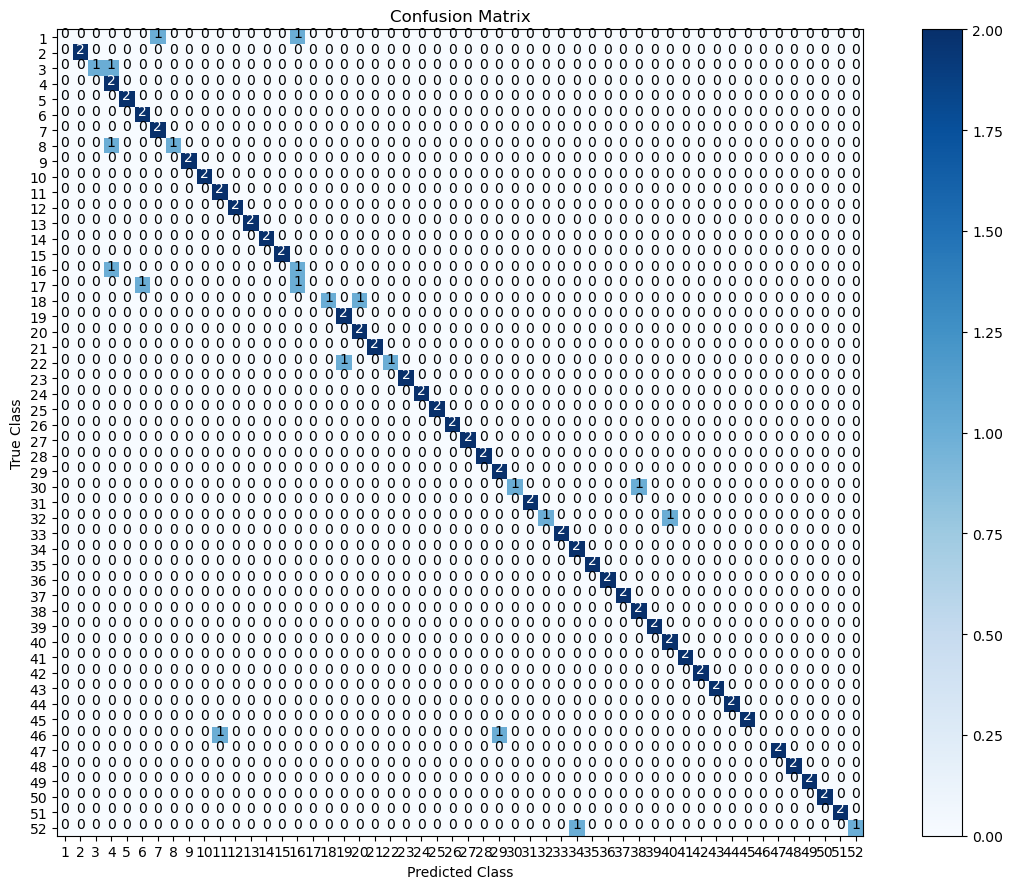

In [35]:
# 3-1-3

mpca = 150
mlda = 50
n_nearest = 5

# pca-lda classifier
test_pred = plm.pca_lda_classifier(train_data, train_label, mean_face, test_data, Mpca=mpca, Mlda=mlda, knn=n_nearest)

# confusion matrix
cm = confusion_matrix(test_label, test_pred, labels = np.arange(1, 53))

# visualize cm
plt.figure(figsize=(12, 9))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

# set axis label
tick_marks = np.arange(len(np.arange(1, 53)))
plt.xticks(tick_marks, np.arange(1, 53))
plt.yticks(tick_marks, np.arange(1, 53))

# fill each cell
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j], 
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.tight_layout()
plt.show()

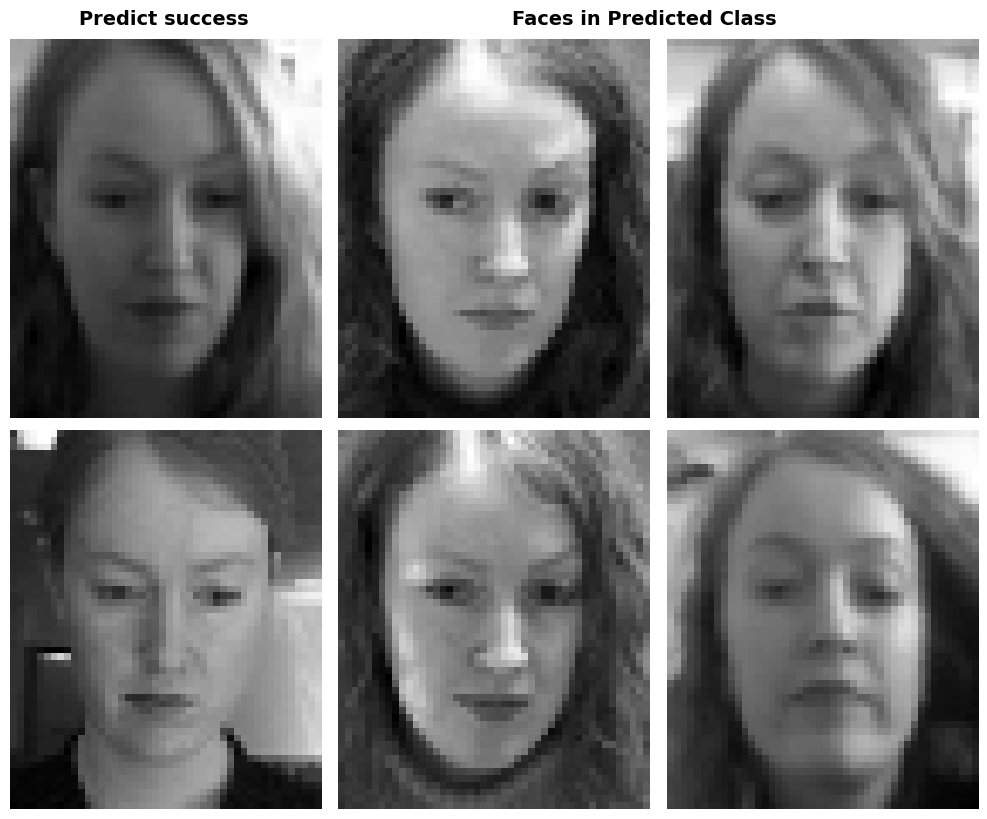

In [24]:
# 3-1-3 success examples

images_success = [test_data.T[2].reshape(46, -1).T, test_data.T[3].reshape(46, -1).T]  # Predict Succeeded Faces (2개)
images_predicted = [train_data.T[8].reshape(46, -1).T, train_data.T[9].reshape(46, -1).T, train_data.T[10].reshape(46, -1).T, train_data.T[11].reshape(46, -1).T]  # Faces in Predicted Class (4개)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))

# faces that fail to predict (class 2)
axes[1, 0].axis('off')  
fig.text(0.17, 1.0, 'Predict success', fontsize=14, fontweight='bold', ha='center')
for i in range(len(images_success)):
    axes[i, 0].imshow(images_success[i], cmap='gray')
    axes[i, 0].axis('off')  

# Faces in predicted class
axes[1, 0].axis('off')  
fig.text(0.65, 1.0, 'Faces in Predicted Class', fontsize=14, fontweight='bold', ha='center')
for i in range(len(images_predicted)):
    axes[i % 2, i // 2 + 1].imshow(images_predicted[i], cmap='gray')
    axes[i % 2, i // 2 + 1].axis('off')

plt.tight_layout()
plt.show()


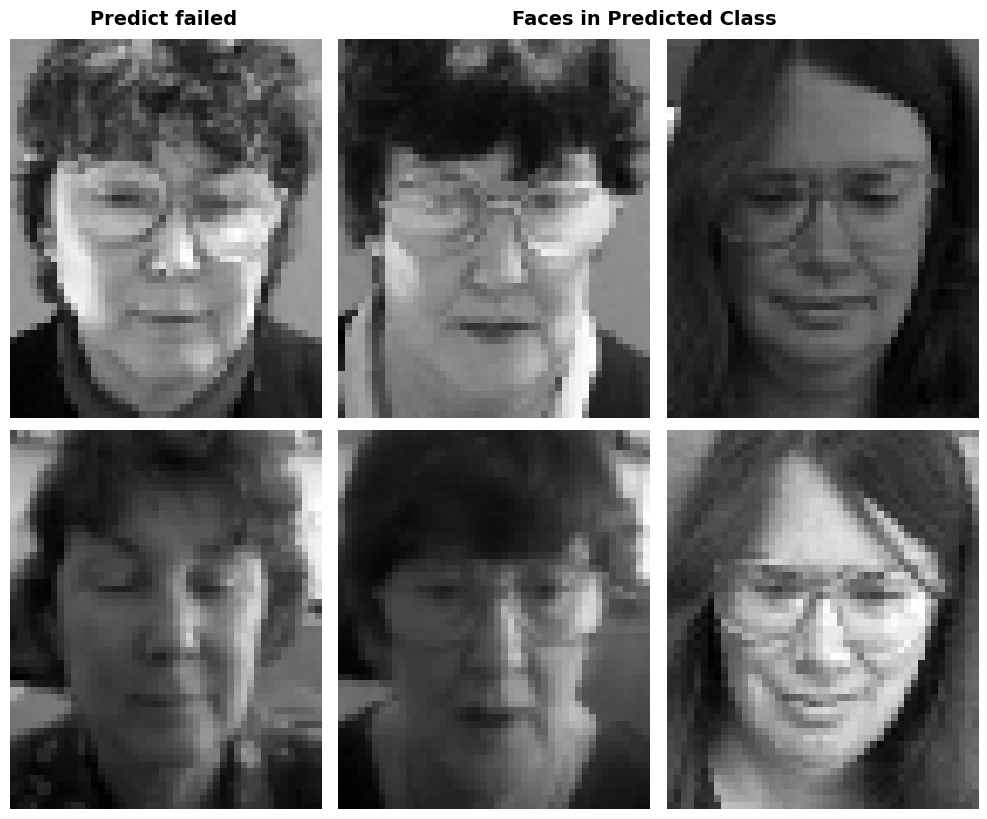

In [23]:
# 3-1-3 failure examples

images_success = [test_data.T[0].reshape(46, -1).T, test_data.T[1].reshape(46, -1).T]  # Predict Succeeded Faces (2개)
images_predicted = [train_data.T[48].reshape(46, -1).T, train_data.T[50].reshape(46, -1).T, train_data.T[124].reshape(46, -1).T, train_data.T[126].reshape(46, -1).T]  # Faces in Predicted Class (4개)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))

# faces that fail to predict (class 1)
axes[1, 0].axis('off')  
fig.text(0.17, 1.0, 'Predict failed', fontsize=14, fontweight='bold', ha='center')
for i in range(len(images_success)):
    axes[i, 0].imshow(images_success[i], cmap='gray')
    axes[i, 0].axis('off')  

# Faces in predicted class (class 7, 16)
axes[1, 0].axis('off')  
fig.text(0.65, 1.0, 'Faces in Predicted Class', fontsize=14, fontweight='bold', ha='center')
for i in range(len(images_predicted)):
    axes[i % 2, i // 2 + 1].imshow(images_predicted[i], cmap='gray')
    axes[i % 2, i // 2 + 1].axis('off')

plt.tight_layout()
plt.show()

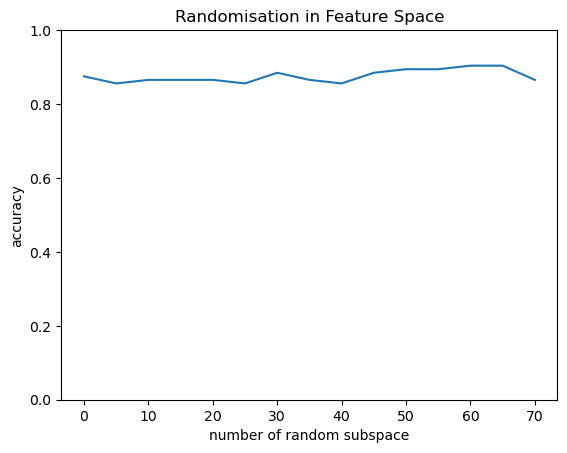

In [8]:
# 3-2-1

mpca = 150
# m0 = 190
mlda = 50
n_nearest = 5
model_num = 10

# pca-lda ensemble

feature_rs = []
accuracy = []

for i in range(15):
    m0 = mpca - 5*i
    ensemble_test_pred = []
    for j in range(model_num): # feature space random sampling, model_num times
        ensemble_test_pred.append(plm.pca_lda_classifier(train_data, train_label, mean_face, test_data, Mpca=mpca, M0=m0, Mlda=mlda, rs=True))
    ensemble_test_pred = mode(ensemble_test_pred, axis=0, keepdims=True).mode.flatten()
    ensemble_accuracy = np.mean(ensemble_test_pred == test_label)
    feature_rs.append(5*i)
    accuracy.append(ensemble_accuracy)

feature_rs = np.array(feature_rs)
accuracy = np.array(accuracy)

plt.plot(feature_rs, accuracy)
plt.xlabel('number of random subspace')
plt.ylabel('accuracy')
plt.ylim([0.0, 1.0])
plt.title('Randomisation in Feature Space')
plt.show()

# 여러번 해봤는데 m0 = 150 - 30 일때 정확도 가장 높은듯

In [6]:
# 3-2-2

mpca = 150
mlda = 50
n_nearest = 5
model_num = 10

# pca-lda ensemble

data_rs = []
accuracy = []

for i in range(10):
    rate = 1.0 - 0.05*i
    train_data_rs = plm.training_data_rs(train_data, model_num, subset_rate = rate) # training data random sampling, model_num times

    ensemble_test_pred = []
    for dataset in train_data_rs:
        sample_mean = np.mean(dataset[0], axis=1).reshape(-1, 1)
        ensemble_test_pred.append(plm.pca_lda_classifier(dataset[0], dataset[1], sample_mean, test_data, Mpca=mpca, Mlda=mlda))

    ensemble_test_pred = mode(ensemble_test_pred, axis=0, keepdims=True).mode.flatten()
    ensemble_accuracy = np.mean(ensemble_test_pred == test_label)

    data_rs.append(rate)
    accuracy.append(ensemble_accuracy)

data_rs = np.array(data_rs)
accuracy = np.array(accuracy)

plt.plot(data_rs, accuracy)
plt.xlabel('number of random subspace')
plt.ylabel('accuracy')
plt.ylim([0.0, 1.0])
plt.title('Randomisation in Data Sampling')
plt.show()

# 정확도 왔다갔다..하지만 subsampling 많이 할수록 좋은듯

NameError: name 'train_label' is not defined

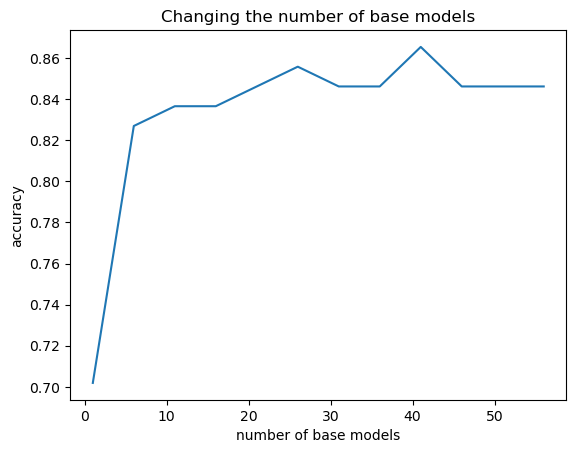

In [ ]:
# 3-2-3

mpca = 200
mlda = 50
m0 = 30
n_nearest = 4
# model_num = 8

# pca-lda ensemble

num_of_models = []
accuracy = []

for i in range(1,61,5):
    model_num = i
    train_data_rs = plm.training_data_rs(train_data, model_num, subset_rate = 0.9) # training data random sampling, model_num times

    ensemble_test_pred = []

    for dataset in train_data_rs:
        sample_mean = np.mean(dataset[0], axis=1).reshape(-1, 1)
        ensemble_test_pred.append(plm.pca_lda_classifier(dataset[0], dataset[1], sample_mean, test_data, Mpca=mpca, Mlda=mlda))

    for j in range(model_num): # feature space random sampling, model_num times
        ensemble_test_pred.append(plm.pca_lda_classifier(train_data, train_label, mean_face, test_data, Mpca=mpca, M0=m0, Mlda=mlda, rs=True))

    ensemble_test_pred = mode(ensemble_test_pred, axis=0, keepdims=True).mode.flatten()
    ensemble_accuracy = np.mean(ensemble_test_pred == test_label)

    num_of_models.append(model_num)
    accuracy.append(ensemble_accuracy)

data_rs = np.array(num_of_models)
accuracy = np.array(accuracy)

plt.plot(data_rs, accuracy)
plt.xlabel('number of base models')
plt.ylabel('accuracy')
plt.title('Changing the number of base models')
plt.show()

# randomness parameter는 어떻게 하는거지??
# base model의 수는 30 이상으로는 성능 거의 비슷한듯. 왔다갔다 함..

In [44]:
# 3-2-4

mpca = 150
mlda = 50
m0 = 30
n_nearest = 5
model_num = 30

# pca-lda ensemble

accuracy = []

train_data_rs = plm.training_data_rs(train_data, model_num, subset_rate = 0.9) # training data random sampling, model_num times
ensemble_test_pred = []

for dataset in train_data_rs:
    sample_mean = np.mean(dataset[0], axis=1).reshape(-1, 1)
    pred_result = plm.pca_lda_classifier(dataset[0], dataset[1], sample_mean, test_data, Mpca=mpca, Mlda=mlda)
    ensemble_test_pred.append(pred_result)
    accuracy.append(np.mean(pred_result == test_label))

for j in range(model_num): # feature space random sampling, model_num times
    pred_result = plm.pca_lda_classifier(train_data, train_label, mean_face, test_data, Mpca=mpca, M0=m0, Mlda=mlda, rs=True)
    ensemble_test_pred.append(pred_result)
    accuracy.append(np.mean(pred_result == test_label))

ensemble_test_pred = mode(ensemble_test_pred, axis=0, keepdims=True).mode.flatten()
ensemble_accuracy = np.mean(ensemble_test_pred == test_label)

accuracy = np.array(accuracy)
ind_accuracy = np.mean(accuracy)

print("The accuracy of the committee machine: ", ensemble_accuracy)
print("The average accuracy of indivicual models: ", ind_accuracy)

The accuracy of the committee machine:  0.8461538461538461
The average accuracy of indivicual models:  0.7357371794871794


In [ ]:
# 3-2-5
# fusion rule? 은 어떻게 적용하는거지? -> 왜 majority voting을 사용했는지?

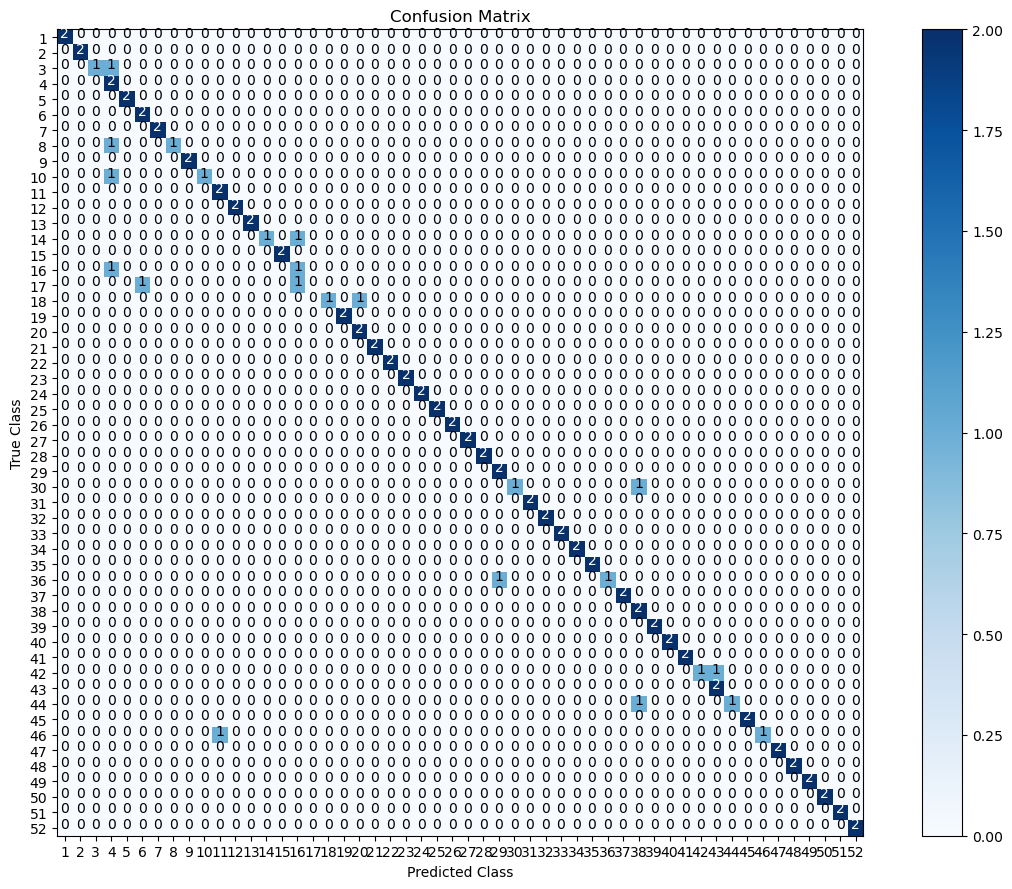

In [46]:
# 3-2-6

mpca = 150
mlda = 50
m0 = 30
n_nearest = 5
model_num = 30

train_data_rs = plm.training_data_rs(train_data, model_num, subset_rate = 0.9) # training data random sampling, model_num times
ensemble_test_pred = []

for dataset in train_data_rs:
    sample_mean = np.mean(dataset[0], axis=1).reshape(-1, 1)
    pred_result = plm.pca_lda_classifier(dataset[0], dataset[1], sample_mean, test_data, Mpca=mpca, Mlda=mlda)
    ensemble_test_pred.append(pred_result)

for j in range(model_num): # feature space random sampling, model_num times
    pred_result = plm.pca_lda_classifier(train_data, train_label, mean_face, test_data, Mpca=mpca, M0=m0, Mlda=mlda, rs=True)
    ensemble_test_pred.append(pred_result)

ensemble_test_pred = mode(ensemble_test_pred, axis=0, keepdims=True).mode.flatten()

# confusion matrix
cm = confusion_matrix(test_label, ensemble_test_pred, labels = np.arange(1, 53))

# visualize cm
plt.figure(figsize=(12, 9))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

# set axis label
tick_marks = np.arange(len(np.arange(1, 53)))
plt.xticks(tick_marks, np.arange(1, 53))
plt.yticks(tick_marks, np.arange(1, 53))

# fill each cell
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j], 
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.tight_layout()
plt.show()